In [1]:
from neuralNetwork import DataLoader, EvaluateNN, ConvNN, torch, datasets, transforms, nn, plt, sns
from sklearn.metrics import confusion_matrix

In [2]:
MODEL_PATH = 'acc81.5/best_model.pth'
DIR_PATH = 'dataset'
TRAIN_PATH = f'{DIR_PATH}/train'
BATCH_SIZE = 32

In [3]:
def map_to_color(labels, class_names):
    """Maps card labels to colors (red or black)"""
    color_map = []
    for label in labels:
        class_name = class_names[label]
        if "diamonds" in class_name or "hearts" in class_name:
            color_map.append(0)  # czerwony = 0
        else:
            color_map.append(1)  # czarny = 1
    return color_map

def map_to_suits(labels, class_names):
    suit_map = []
    for label in labels:
        class_name = class_names[label]
        if "joker" in class_name:
            suit_map.append(None)
            continue
        if "clubs" in class_name:
            suit_map.append(0)
        elif "diamonds" in class_name:
            suit_map.append(1)
        elif "hearts" in class_name:
            suit_map.append(2)
        elif "spades" in class_name:
            suit_map.append(3)
    return suit_map

def map_to_ranks(labels, class_names):
    """Maps cards to ranks"""
    rank_map = []
    ranks = {
        "ace": 0, "two": 1, "three": 2, "four": 3, "five": 4, 
        "six": 5, "seven": 6, "eight": 7, "nine": 8, "ten": 9,
        "jack": 10, "queen": 11, "king": 12
    }
    
    for label in labels:
        class_name = class_names[label]
        if "joker" in class_name:
            rank_map.append(13)
            continue
        
        for rank_name, rank_value in ranks.items():
            if rank_name in class_name:
                rank_map.append(rank_value)
                break
    return rank_map

In [4]:
criterion = nn.CrossEntropyLoss()
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
test_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=val_test_transform)

In [6]:
model = ConvNN(num_classes=53)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [7]:
num_splits = 5
subset_size = len(test_dataset) // num_splits
accuracy = []

all_preds = []
all_targets = []

for i in range(num_splits):
    indices = list(range(i * subset_size, (i + 1) * subset_size))
    subset = torch.utils.data.Subset(test_dataset, indices)
    subset_loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    acc = EvaluateNN.test(model, subset_loader, criterion, device)
    accuracy.append(acc)

    with torch.no_grad():
        for images, labels in subset_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

Testing: 100%|██████████| 48/48 [00:56<00:00,  1.17s/it, accuracy=85.2, l=0.491] 


Test loss: 0.4905, Accuracy: 85.17060367454069%


Testing: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s, accuracy=79.1, l=0.664]


Test loss: 0.6636, Accuracy: 79.13385826771653%


Testing: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s, accuracy=78.9, l=0.767]


Test loss: 0.7674, Accuracy: 78.93700787401575%


Testing: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s, accuracy=76.3, l=0.782]


Test loss: 0.7816, Accuracy: 76.31233595800525%


Testing: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s, accuracy=82.9, l=0.553]


Test loss: 0.5534, Accuracy: 82.93963254593176%


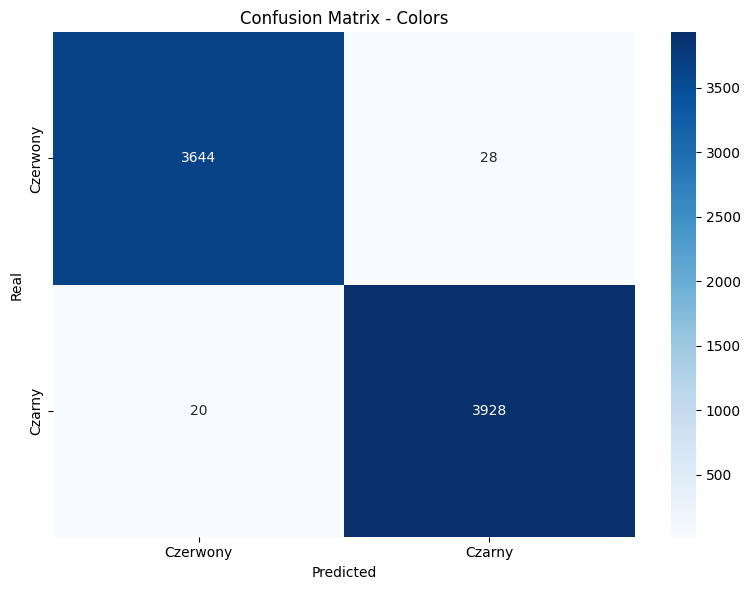

In [8]:
targets_color = map_to_color(all_targets, test_dataset.classes)
preds_color = map_to_color(all_preds, test_dataset.classes)
cm_color = confusion_matrix(targets_color, preds_color)

plt.figure(figsize=(8, 6))
color_names = ["Czerwony", "Czarny"]
sns.heatmap(cm_color, annot=True, fmt="d", cmap="Blues", 
            xticklabels=color_names, yticklabels=color_names)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix - Colors')
plt.tight_layout()
plt.show()

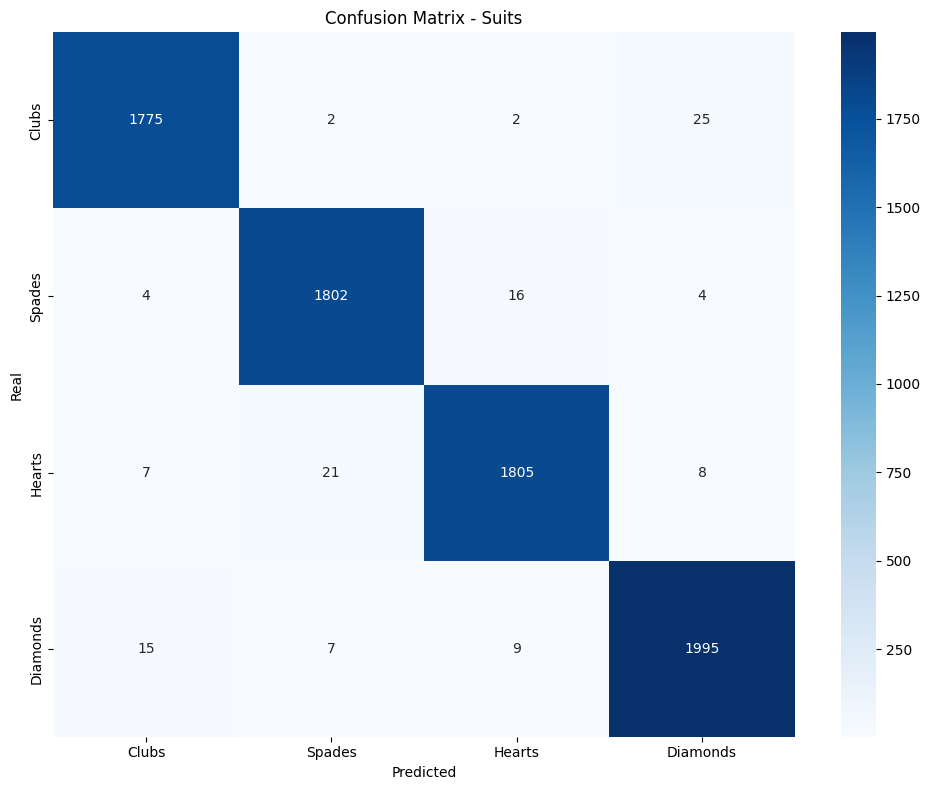

In [ ]:
targets_suit = map_to_suits(all_targets, test_dataset.classes)
preds_suit = map_to_suits(all_preds, test_dataset.classes)

targets_suit_filtered = []
preds_suit_filtered = []

for t, p in zip(targets_suit, preds_suit):
    if t is not None and p is not None:
        targets_suit_filtered.append(t)
        preds_suit_filtered.append(p)

cm_suit = confusion_matrix(targets_suit_filtered, preds_suit_filtered)


plt.figure(figsize=(10, 8))
suit_names = ["Clubs", "Spades", "Hearts", "Diamonds"]
sns.heatmap(cm_suit, annot=True, fmt="d", cmap="Blues", 
            xticklabels=suit_names, yticklabels=suit_names)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Real', fontsize=16)
plt.title('Confusion Matrix - Suits', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


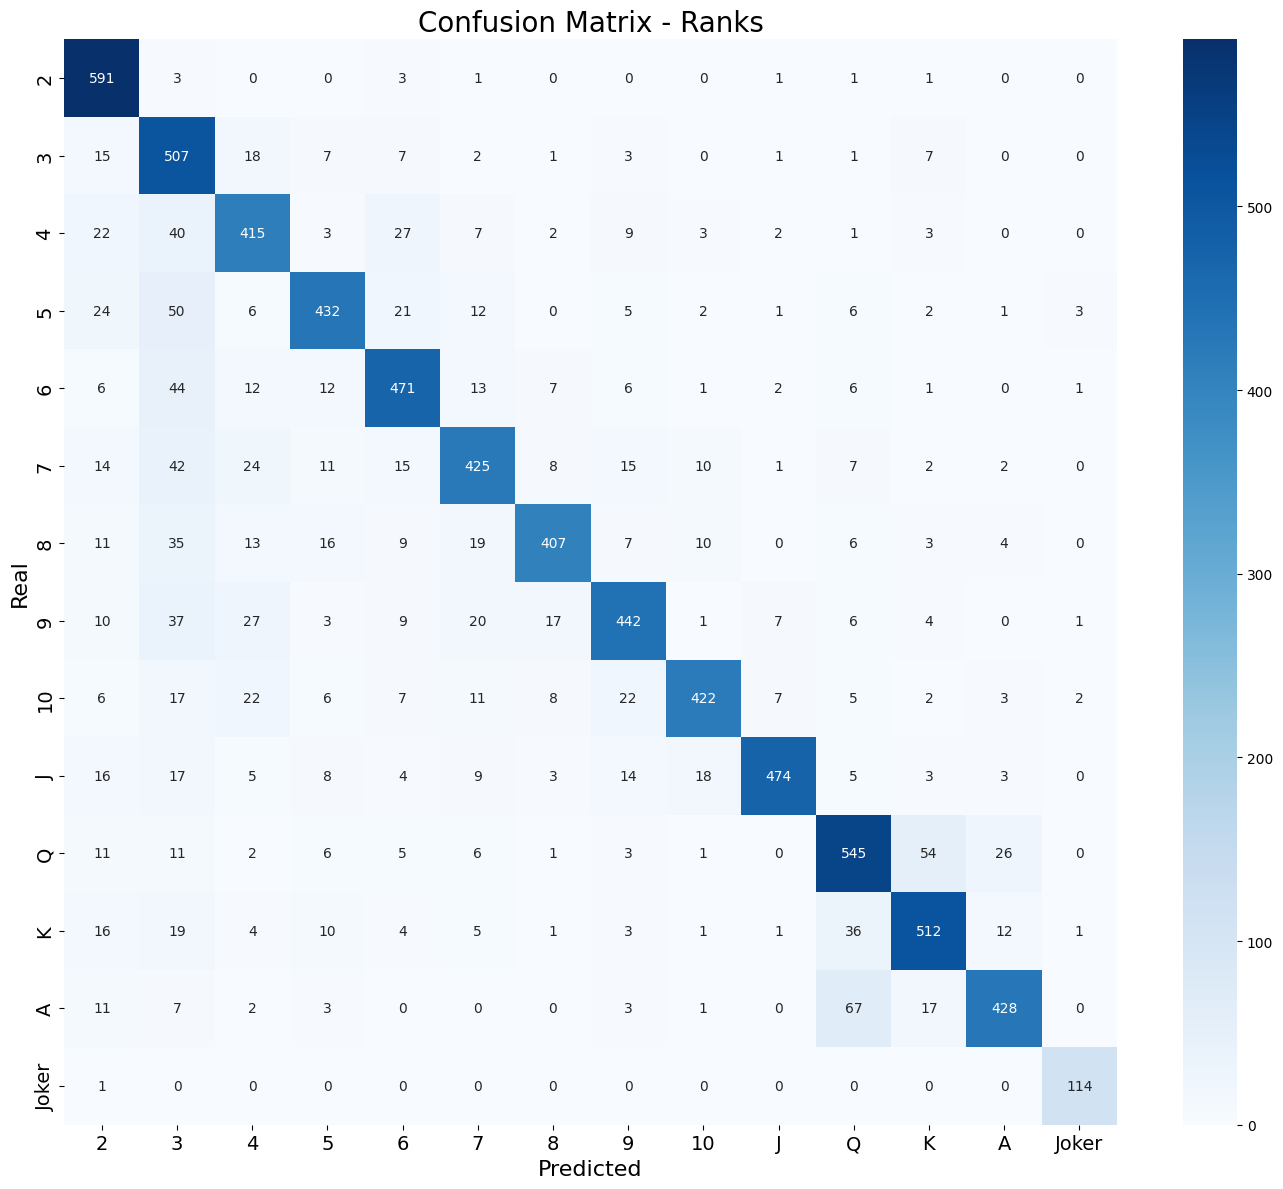

In [10]:
targets_rank = map_to_ranks(all_targets, test_dataset.classes)
preds_rank = map_to_ranks(all_preds, test_dataset.classes)
cm_rank = confusion_matrix(targets_rank, preds_rank)

plt.figure(figsize=(14, 12))
rank_names = ["2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K", "A", "Joker"]
sns.heatmap(cm_rank, annot=True, fmt="d", cmap="Blues", 
            xticklabels=rank_names, yticklabels=rank_names)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Real', fontsize=16)
plt.title('Confusion Matrix - Ranks', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

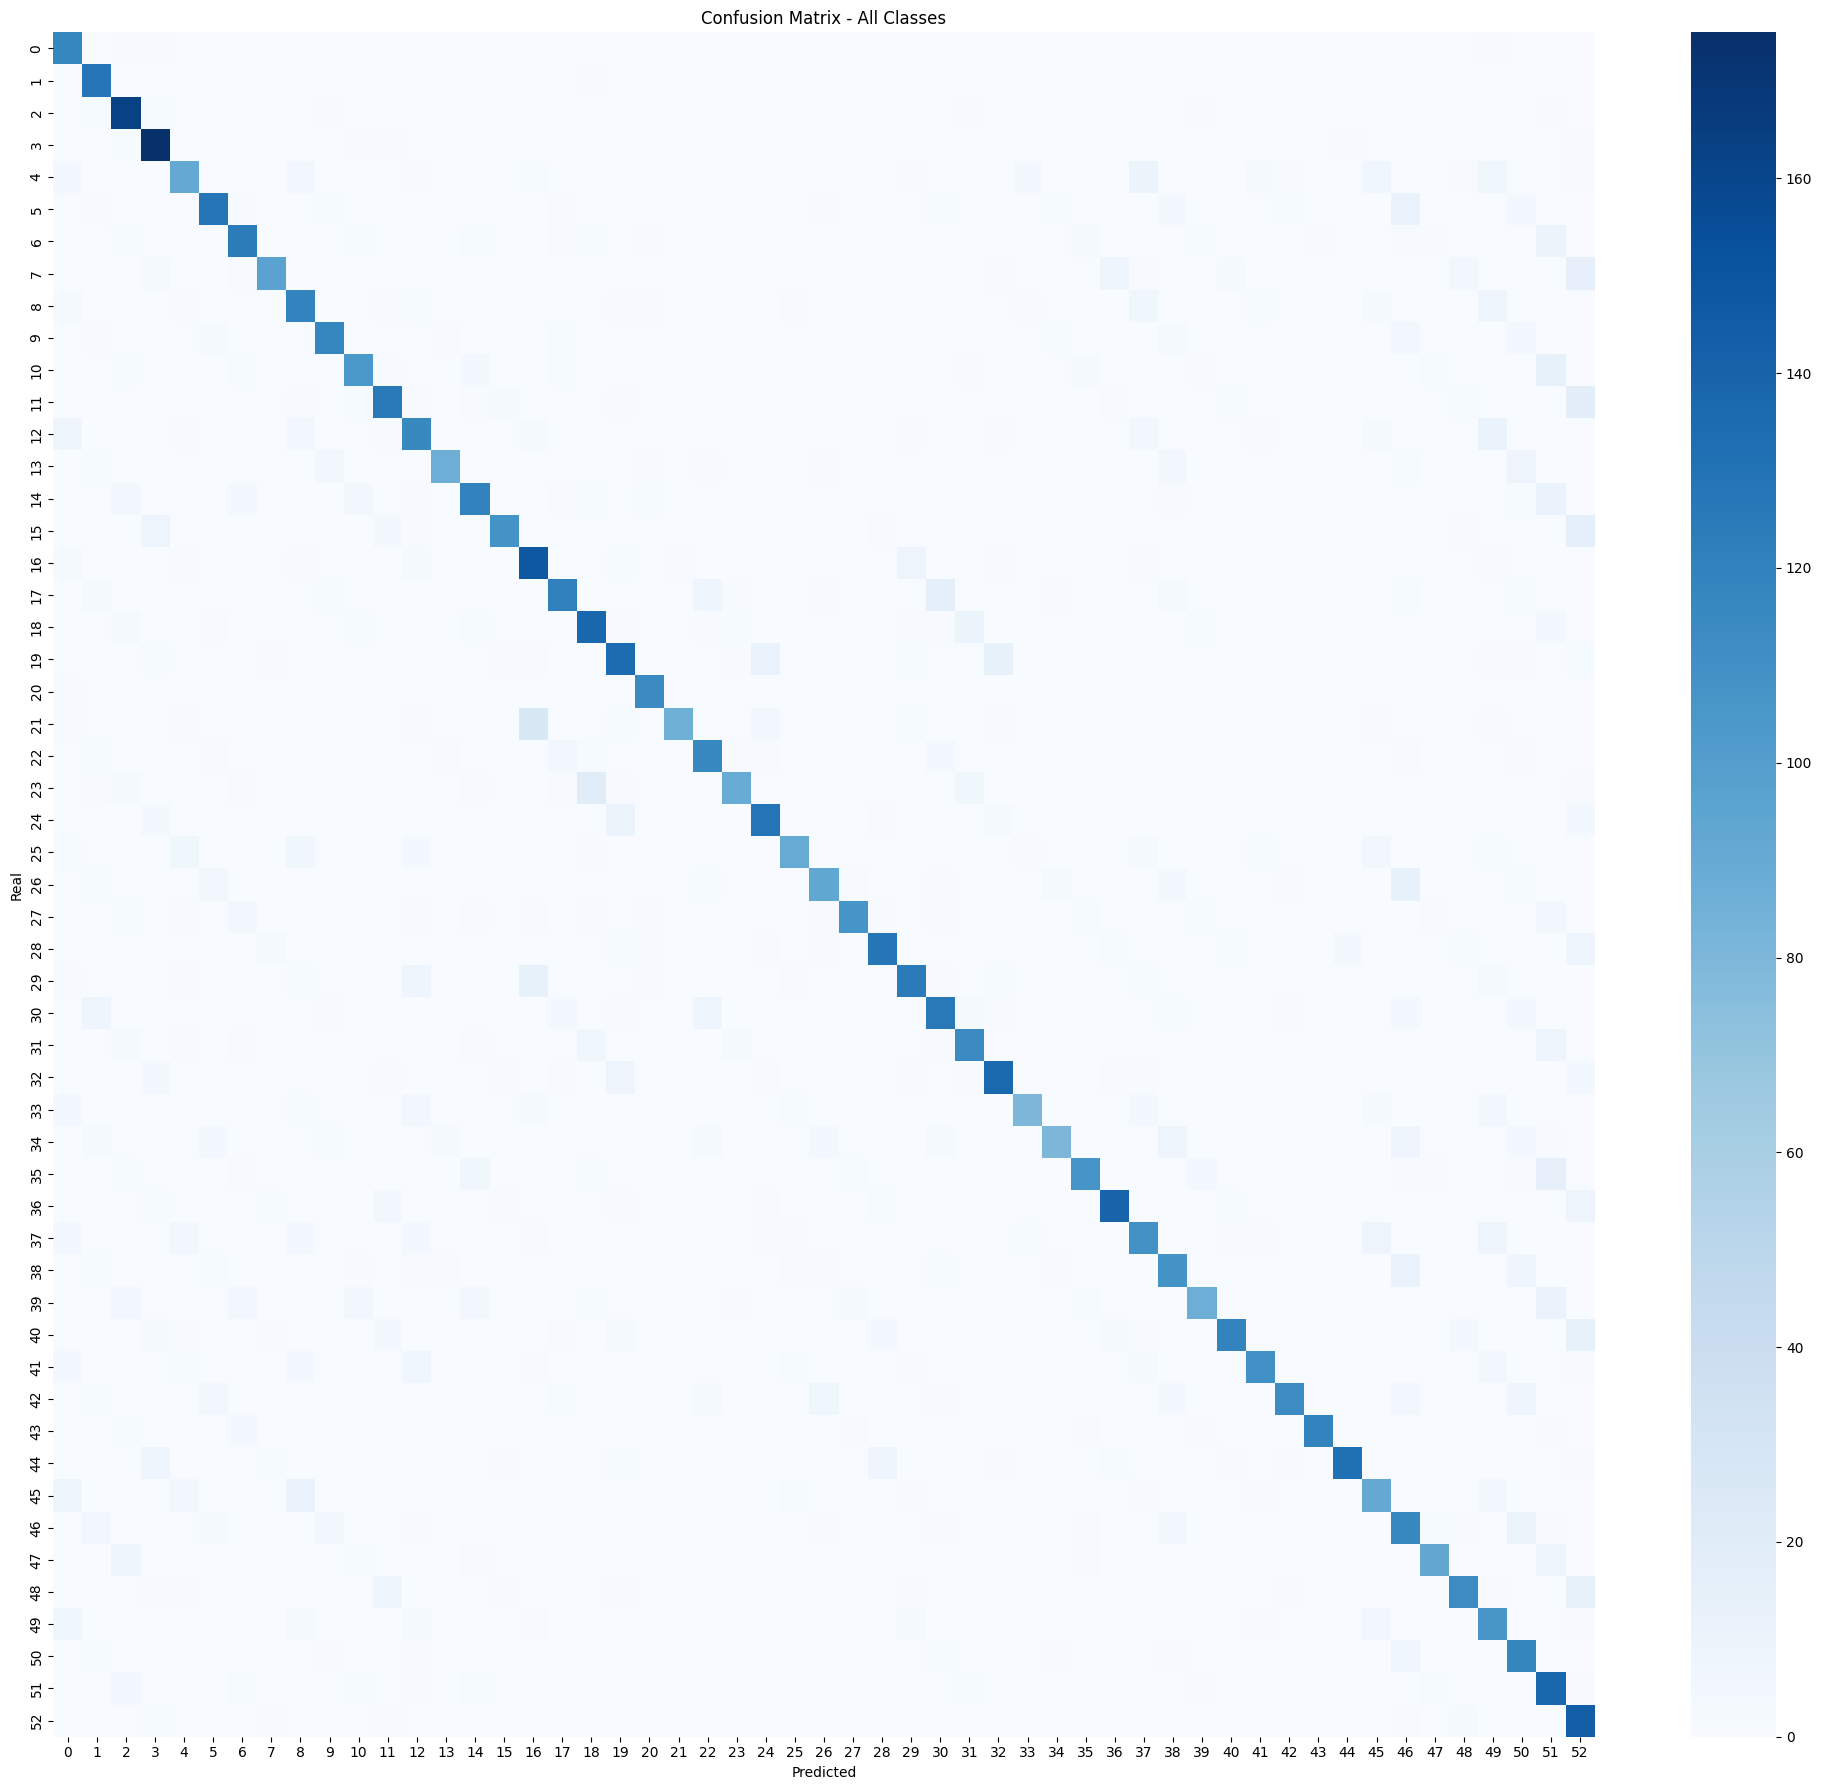

In [11]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(20, 18))
plt.title('Confusion Matrix - All Classes')
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.tight_layout()
plt.show()